In [1]:
import json
import torch
import argparse
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torchvision.transforms import v2
from PIL import Image
import matplotlib.pyplot as plt

import timm
from utils.dataset import ImigueDS

## Visualize sample

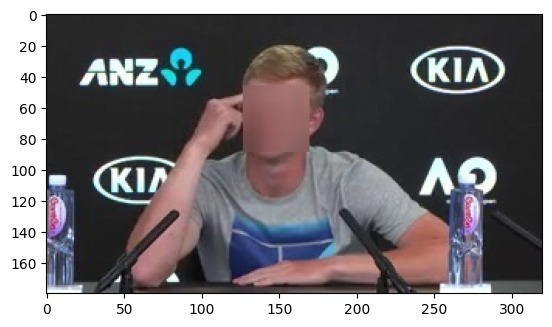

In [2]:
path = "./data/training"

dataset = ImigueDS(path)
batch = dataset[100]
img, label = batch
plt.imshow(img[0].permute(1,2,0)*0.5 + 0.5)

## Training

In [16]:
import numpy as np
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from sklearn.model_selection import  train_test_split
from collections import Counter
from utils.misc import stratified_split

# Create resnet18 model
model = timm.create_model('resnet18', pretrained=True, num_classes=0)

# Create Transform
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
transform
path = "./data/training"

# Create the full dataset first
dataset = ImigueDS(path, transform=transform)


train, valid = stratified_split(dataset)
model.num_features

train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=4)
batch = next(iter(train_loader))

In [17]:

feature_dim = model.num_features

# Transformer Encoder for Temporal Modeling
encoder_layer = nn.TransformerEncoderLayer(d_model=feature_dim, nhead=8, dim_feedforward=1024, dropout=0.1, batch_first=True)
transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)

# Classification Head
fc = nn.Linear(feature_dim, 32)

# Loss function & Metrics
criterion = nn.CrossEntropyLoss()

In [18]:
img, label = batch
batch_size, num_frames, C, H, W = img.shape

img.shape

x = img.view(batch_size * num_frames, C, H, W)  # (batch_size * num_frames, C, H, W)

print(x.shape)
features = model(x)  # Extract per-frame features

torch.Size([320, 3, 224, 224])


In [23]:
print(features.shape)
features = features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_dim)
print(features.shape)
print(features[0][0])

torch.Size([32, 10, 512])
torch.Size([32, 10, 512])
tensor([1.2396e-01, 4.9402e-03, 1.4636e-01, 1.6173e-01, 2.9221e-01, 1.5258e-01,
        4.2305e-01, 3.4621e-01, 1.3811e-01, 9.8991e-02, 3.5561e-01, 4.4417e-01,
        6.2521e-02, 2.1377e-01, 3.1336e-02, 2.4478e-01, 8.1370e-02, 2.7789e-01,
        3.9356e-01, 4.4381e-01, 1.6556e-01, 2.9956e-01, 9.1406e-02, 1.7521e-01,
        3.4149e-02, 1.5307e-01, 3.8651e-01, 1.2312e-01, 3.9795e-01, 6.9986e-01,
        5.2181e-01, 2.0802e-01, 4.0977e-02, 1.2367e-02, 4.7800e-02, 3.5259e-02,
        2.0513e-01, 1.9602e-01, 2.6490e-01, 7.2215e-02, 7.9724e-03, 4.7197e-01,
        3.8511e-02, 1.0571e-01, 1.2013e-01, 3.4208e-01, 3.5913e-02, 2.1018e-01,
        4.0769e-01, 9.8611e-02, 1.7134e-01, 3.6774e-01, 3.2024e-01, 3.2087e-01,
        3.6572e-01, 7.0532e-03, 2.1523e-01, 4.0911e-02, 9.4785e-02, 2.3645e-01,
        2.2423e-01, 1.6012e-01, 3.7558e-01, 5.2128e-01, 7.0266e-02, 2.0815e-01,
        9.3949e-02, 1.2139e-01, 1.7880e-01, 3.1679e-01, 1.8981e-02, 

In [33]:

transformer_out = transformer(features)  # (num_frames, batch_size, feature_dim)
print(transformer_out.shape)
out = transformer_out[:, -1, :]
print(out.shape)
logits = fc(out)
logits.shape
print(label.shape)

torch.Size([32, 10, 512])
torch.Size([32, 512])
torch.Size([32])


In [ ]:

# Transformer expects (batch_size, num_frames, feature_dim)
# Temporal modeling using Transformer Encoder

# Aggregate over time dimension (mean pooling)
out = transformer_out.mean(dim=0)